# Experiment 2 - Fine Tuning Analysis Pipeline
*By Andrew Balch, Kyan Yang*

In [1]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math
from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt
import plotly.graph_objects as go
%matplotlib inline 

## Background Removal (leave for later?)
*This one may be put on hold since I have no idea how it will impact the spectral information in the image.*

Test different methods of background removal (by subtraction). The original idea was to use ImageJ's sliding paraboloid method and test different radiuses. A github implementation in opencv is available [here](https://github.com/mbalatsko/opencv-rolling-ball). Open-CV has its own built-in methods of background subtraction that could also be tested, but I like the idea of using the sliding paraboloid better since it was developed for biomedical applications. **Keep in mind that we only want background subtraction to impact the area outside of the emission lines.**

In [2]:
def background_rm():
    return

## Image Transformation (manual during profile generation)
For proper analysis, all images within the same experimental setup generation must have near-identical regions of interest (ROIs). Meaning, the spectra should be horizontal with the colors going from blue on the right to red on the left. This is easier for Gen 2 images, but all Gen 1 images have an awkward angle that must be accounted for (see below).

Two methods for adjusting for this were considered. Rotation ~90 deg ccw makes emission lines vertical, but the overall spectra will be slanted towards the lower right corner. This means that the region of interest will include the bottom of the blue emission line straight through to the top of the red emission line. Rotation ~105 deg ccw makes the spectra roughly horizontal but the emission lines themselves will have an obtuse angle. With this a straight line can be drawn through the center of all of the emission lines, but profile generation will include the background in the vertical space at a pixel position in the x-axis at the edges of each emission lines. The resulting profiles of a blank sample with an LED bulb source for these two methods were overlaid to demonstrate their differences (see below). As the resulting profile shapes are near identical, we will use 90 deg ccw rotation for simplicity.

|Gen 1 Calibration Image|Gen 2 Calibration Image|
|:-:|:-:|
|![Gen 1](./Spectra/Gen%201/Calibration/IMG_6421.JPG "Gen 1 Calibration Image")|![Gen 2](./Spectra/Gen%202/Calibration/IMG_6561.JPG "Gen 2 Calibration Image")|

Profile comparisons

![Profile comparison](Gen%201%20LED%20Bulb%20Rotation%20Comparison.jpg)

## Image Profile Generation (manual)
Profile data for each sample can be found as a csv in the same directory as the images with the naming convention "<image_name>_profile.csv". The xy coordinates defining the region are saved as csv in the same location with the name "region.csv". All regions have a 50 pixel height and have the same length within a experimental setup generation. Regions were kept constant for all three images collected but differ from sample to sample.

ImageJ's [Plot Profile](https://imagej.nih.gov/ij/docs/guide/146-30.html#toc-Subsection-30.11) feature as closely as possible. The feature takes a rectangular region through the center of the spectra (the ROI) and averaging the pixel intensity values in the y-axis (the height of the region) for each pixel in the x-axis (the length of the region). In other words, we want an array with the same size as the length of the image (in pixels) where each element is the averaged intensity of a vertical slice at that pixel.

Example ImageJ Profile Generation of CFL Spectra in Gen 2 Setup

![Example ImageJ Profile Generation of CFL Spectra in Gen 2 Setup](Profile_Example.jpg)

## Peak Detection
By-the-book and CWT peak detection for any input series (image profile, absorbance, transmission). I've determined that a CWT widths of 5 and 10 or a prominence of 4 works well for CFL peak detection. This [paper](doi.org/10.1186/1471-2105-10-4) recommends a peakScaleRange (which I assume is analogous to widths) parameter of [2,4,6], but this results in a much larger number of peaks.

In [3]:
def calc_peaks(series, method="cwt"):
    """Method param can be one of "cwt" (default) or "norm" """
    if method == "norm":
        return find_peaks(series, prominence=4)[0]
    return find_peaks_cwt(series, np.array([5, 10]))

## Calibration to CFL Spectrum
The profile for each image is a dataset of average intensity values for each pixel in the length of the ROI. We need to map these pixel positions to wavelengths to generate absorption and transmission spectra. To do this, we fit a linear equation to pixel positions of known emission peaks of a compact fluorescent light (CFL) ([source](https://commons.wikimedia.org/wiki/File:Fluorescent_lighting_spectrum_peaks_labelled.png)). We calibrate upon the three most prominent CFL peaks at 436.6, 487.7, 546.5, and 611.6 nm.

Each generation has its own set of calibration images of a blank sample with a CFL source. We'll create the calibration equation using the helper code below. It allows us to get the profiles of each calibration image, run CWT peak detection with widths of 5 and 10, then plot the data. Visual inspection of the profile plot and these peaks will reveal which pixel positions correspond to the wavelengths at which CFL peaks are known to occur (see the below example). Finding a line of best fit through these pixel position & wavelength points gives us the calibration equation (see 'calibration.xlsx' spreadsheets in /Spectra/Gen #/Calibration).

Example calibration spectra: (red sections are noise, notice that the green peak at 546.6 nm is at a secondary, slightly lower peak than one directly to the left of it)

![Labeled calibration spectra](Labeled_calibration_spectra.jpg)

In [4]:
# HELPER CODE, not part of pipeline
# cal_data = pd.read_csv("Spectra\Gen 1\Calibration\IMG_6426_profile.csv")

# peaks = calc_peaks(cal_data['Gray_Value'])

# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=cal_data['Distance_(pixels)'],
#     y=cal_data['Gray_Value'],
#     mode='lines',
#     name='Spectrum'
# ))

# fig.add_trace(go.Scatter(
#     x=peaks,
#     y=[cal_data['Gray_Value'][i] for i in peaks],
#     mode='markers',
#     name='Peaks'
# ))

# fig.show()

In [5]:
def calibrate_wavelength(dataset, gen):
    """Applies calibration equation on the 'Distance_(pixels)' column of a provided image profile dataframe, renames the column to 'Wavelength', and 
    returns the resulting dataframe. Calibration equation is specific to the specified testing generation."""
    assert gen == 1 or gen == 2, "Invalid second argument 'gen'! Must be 1 or 2 matching the experimental setup generation of the input dataset"

    eqn = None
    if gen == 1: 
        # y=0.2362x+181.18
        eqn = lambda x: 0.2362 * x + 181.18

    elif gen == 2:
        # y=0.2312x+77.887
        eqn = lambda x: 0.2312 * x + 77.887

    return pd.DataFrame({"Wavelength": dataset['Distance_(pixels)'].apply(eqn),
                         "Gray_Value": dataset['Gray_Value']})

# test_data = pd.read_csv("Spectra\Gen 1\Calibration\IMG_6426_profile.csv")

# calibrated_data = calibrate_wavelength(test_data)

# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=cal_data['Distance_(pixels)'],
#     y=cal_data['Gray_Value'],
#     mode='lines',
#     name='Spectrum'
# ))

## Moving Averages
After we have mapped pixel positions to wavelengths with the calibration equation we want to experiment with taking a moving average across the series. Basically, we have a window of a specified size (in nm, wavelength units) and we take the average over all of the intensity values at a wavelength in that window, then move to the next (this is actually not accurate to what a moving average actually is). For example, a window of 5 nm would average the intensities within 400 to 405 nm, then those within 405 to 410, etc. 

We want to test 4 window lengths:
1. None 
2. 3 nm
3. 5 nm
4. 10 nm

**Note:** Taking the moving average will result in having a single value represent a range of wavelengths. To get around any issues this may cause, we'll say that the averaged value is at all wavelengths in the range. Ex\) The average in a window from 400 to 405 nm will be the value at 400 nm, 401 nm, etc

In [ ]:
def moving_average(dataframe, window_len=0):
    if window_len > 0:
        i = 0
        while i < len(dataframe):
            window_intensity = 0
            j = i
            while (dataframe.iat[j,0] < dataframe.iat[i,0]+window_len):
                window_intensity += dataframe.iat[j,1]
                j += 1
                if (j >= len(dataframe)):
                    break
            avg = window_intensity/(j-i)
            for k in range(i, j):
                dataframe.loc[k, 'Gray_Value'] = avg
            i += j-i

# testing
# data = {
#     'Wavelength': [400, 401.5, 403, 404.5, 406, 407.5, 409],
#     'Gray_Value': [45, 50, 55, 60, 65, 70, 75]
# }
# df = pd.DataFrame(data)
# print('BEFORE', df)
# df = moving_average(df, 5)
# print('AFTER', df)

## Reference Calculation Using Blanks
Getting transmission and absorption data requires a reference set for maximum light passthrough (blank samples). We are testing three methods for this: 
1. Averaging the profiles for each blank sample
2. Taking the "maximum" profile curve (the single sample with the largest intensity values overall)
3. Taking the argmax of all samples (largest intensity at a wavelength across all blanks)

In [ ]:
def get_reference(pf1, pf2, pf3, method="avg"):
    """Method param can be one of "avg" (default), "maxcurve", or "argmax" """
    
    profiles = [pf1, pf2, pf3]
    new_profile = pd.DataFrame()
    count = 0
    for profile in profiles:
        if len(new_profile) != 0:
            new_profile = pd.merge(new_profile, profile, on='Wavelength', how='inner', suffixes=('_df1', '_df2'))
            if (method == "argmax"):
                new_profile['Gray_Value'] = new_profile[['Gray_Value_df1', 'Gray_Value_df2']].max(axis=1)
            elif (method == "maxcurve"):
                filtered_df = new_profile[(new_profile['Wavelength'] >= 400) & (new_profile['Wavelength'] <= 700)]
                if filtered_df['Gray_Value_df2'].mean() > filtered_df['Gray_Value_df1'].mean():
                    new_profile['Gray_Value'] = new_profile['Gray_Value_df2']
                else:
                    new_profile['Gray_Value'] = new_profile['Gray_Value_df1']
            else:
                new_profile['Gray_Value'] = new_profile['Gray_Value_df1'] + new_profile['Gray_Value_df2']  
            new_profile = new_profile.drop(columns=['Gray_Value_df1', 'Gray_Value_df2'])
        else:
            new_profile = profile
        count += 1
    if (method == "avg"):
        new_profile['Gray_Value'] = new_profile['Gray_Value'] / count
    return new_profile


# testing
# profiles = []
# cfl_blanks_path = r"Spectra\Gen 1\CFL Source\Blank"
# for file in os.listdir(cfl_blanks_path):
#     if file.endswith('.csv') and file.startswith('IMG'):
#         profiles.append(calibrate_wavelength(pd.read_csv(os.path.join(cfl_blanks_path, file)), 1))

# print('avg', get_reference(profiles[0], profiles[1], profiles[2]))

# print('maxcurve', get_reference(profiles[0], profiles[1], profiles[2], 'maxcurve'))

# print('argmax', get_reference(profiles[0], profiles[1], profiles[2], 'argmax'))



## Calculate Transmittance
The transmittance of light through the sample is calculated by dividing the intensity of the sample (transmitted light) by the reference value (incident light) at each wavelength.

In [ ]:
def calc_trans(sample, reference):
    if reference == 0:
        return 0
    return sample/reference

## Calculate Absorbance
Now that we have transmittance, we can calculate the absorbance of light by the sample by the equation: $absorbance=-log_{10}(transmittance)$.

In [ ]:
def calc_abs(transmittance):
    if transmittance == 0:
        return 0
    return -1*math.log10(transmittance)

## Driver Code
Putting it all together into a pipeline that takes each image, tests all parameters, and generates graphs and data for inspection. Here is the hierarchy of parameters we want to test: 
* Generation (2 params)
    * Light source (4 params)
        * Background removal (~3 params, if applicable)
            * Reference method (3 params)
                * Moving average (4 params)
                

For each combination of parameters, we want to end up with 3 datasets (plots and raw data): one of the reference, one of all the TJ supplement samples, and another of all the Walgreens samples (288 datasets total, 864 if background removal).

**Notes for implementation:** 
* Calibration eqn only needs to be retrieved once for each generation
* Creating a pandas dataframe could be very helpful for plotting
* Save the data in a file structure that follows the above hierarchy

**Notes for plotting:** 
* Reference plot should be wavelength vs intensity for the method used
* Plots of the supplement samples should include transmittance and absorbance stacked on the same x-axis wavelength. They should also include all tested concentrations as different colored lines with a legend (see below example, ignore concentration)

![Example Plot](example_plot.jpeg)

In [ ]:
def collect_pfs(profiles, path, gen):
    for file in os.listdir(path):
        if file.endswith('.csv') and file.startswith('IMG'):
            profiles.append(calibrate_wavelength(pd.read_csv(os.path.join(path, file)), gen))

Plots\Gen 1\CFL Source\argmax\Win Len 0\RefPlot_Gen1_CFL_argmax_WL0.JPG
Plots\Gen 1\CFL Source\argmax\Win Len 3\RefPlot_Gen1_CFL_argmax_WL3.JPG


KeyboardInterrupt: 

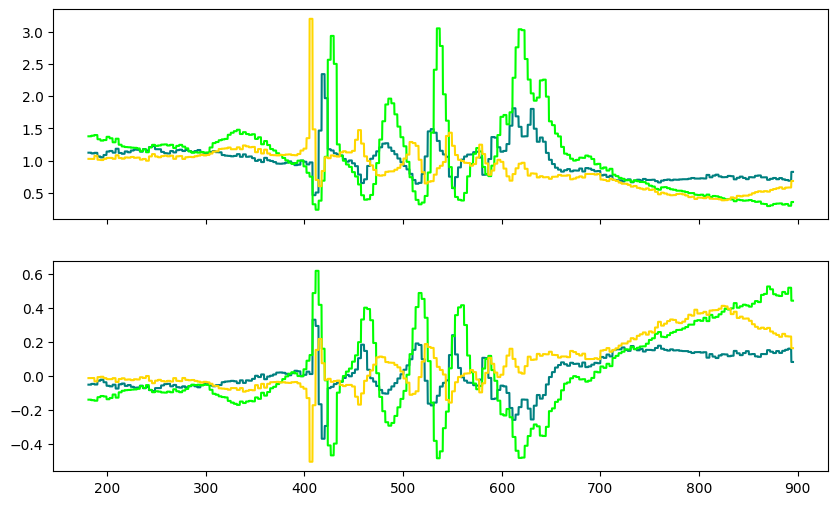

In [ ]:
light_sources = ['CFL', 'LED Bulb', 'LED Matrix', 'Single LED']
ref_methods = ['argmax', 'maxcurve', 'avg']
moving_avg_win_lens = [0, 3, 5, 10]
colors = {'1 mcg': 'teal', '2 mcg': 'lime', '4 mcg': 'gold', '10 mcg': 'orange', '20 mcg': 'orangered'}
conc_list = ['1 mcg', '2 mcg', '4 mcg', '10 mcg', '20 mcg']
for GEN in range(1, 3):
    for LS in light_sources:
        for RM in ref_methods:
            for WIN in moving_avg_win_lens:
                PATH = rf'Spectra\Gen {GEN}\{LS} Source'
                PLOT_PATH = f'Plots\Gen {GEN}\{LS} Source\{RM}\Win Len {WIN}'
                if not os.path.isdir(PLOT_PATH):
                    os.makedirs(PLOT_PATH)
                blanks = []

                # reference
                collect_pfs(blanks, os.path.join(PATH, 'Blank'), GEN)
                reference = get_reference(blanks[0], blanks[1], blanks[2], RM)
                moving_average(reference, WIN)
                ref_plot_path = os.path.join(PLOT_PATH, f'RefPlot_Gen{GEN}_{LS}_{RM}_WL{WIN}.JPG')
                # reference plotting
                fig, ax = plt.subplots(figsize=(10,6))
                ax.plot(reference['Wavelength'], reference['Gray_Value'])
                ax.xaxis.set_ticks_position('bottom')
                ax.xaxis.set_label_position('bottom')
                ax.set_xlabel('Wavelength')
                ax.set_ylabel('Gray Value')
                fig.suptitle(f'Reference -- Gen {GEN}, {LS} Source, {RM} Reference, {WIN} Win Len')
                fig.tight_layout()
                plt.savefig(ref_plot_path, dpi=1200)
                plt.close()

                # save raw data
                reference.to_csv(os.path.join(PLOT_PATH, f'RefData_Gen{GEN}_{LS}_{RM}_WL{WIN}.csv'), index=False)

                # supps
                for store in os.listdir(PATH):
                    if (store != 'Trader Joes' and store != 'Walgreens'):
                        continue

                    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,6))
                    for conc in conc_list:
                        # get profiles
                        conc_profiles = []
                        collect_pfs(conc_profiles, os.path.join(PATH, store, conc), GEN)
                        conc_profile = get_reference(conc_profiles[0], conc_profiles[1], conc_profiles[2], 'avg')
                        moving_average(conc_profile, WIN)

                        # get trans and abs
                        wavelength = conc_profile['Wavelength']
                        gray_value = conc_profile['Gray_Value']
                        transmittance = [calc_trans(gray_value[i], reference.iat[i,1]) for i in range(min(len(gray_value), len(reference)))]
                        absorbance = [calc_abs(t) for t in transmittance]

                        # ensure same size as reference
                        len_w = len(wavelength)
                        len_a = len(absorbance)
                        if (len_w > len_a):
                            wavelength.drop(wavelength.tail(len_w-len_a).index,inplace=True)
                        elif (len_w < len_a):
                            absorbance.drop(absorbance.tail(len_a-len_w).index,inplace=True)
                        
                        # plot
                        ax1.plot(wavelength, transmittance, label=conc, color=colors[conc])
                        ax2.plot(wavelength, absorbance, color=colors[conc])

                        raw_data = pd.DataFrame({'Wavelength': wavelength,
                                                 'Transmittance': transmittance,
                                                 'Absorbance': absorbance})
                        save_path = ''
                        if (store == 'Trader Joes'):
                            save_path = os.path.join(PLOT_PATH, f'Data_TJ_C{conc.split()[0]}_Gen{GEN}_{LS}_{RM}_WL{WIN}.csv')
                        else:
                            save_path = os.path.join(PLOT_PATH, f'Data_WG_C{conc.split()[0]}_Gen{GEN}_{LS}_{RM}_WL{WIN}.csv')
                        raw_data.to_csv(save_path, index=False)

                    # show plot 
                    ax1.set_ylabel('Transmittance')
                    ax2.set_ylabel('Absorbance')
                    ax2.set_xlabel('Wavelength')
                    ax2.xaxis.set_ticks_position('bottom')
                    ax2.xaxis.set_label_position('bottom')

                    ax1.legend()
                    fig.suptitle(f'{store} -- Gen {GEN}, {LS} Source, {RM} Reference, {WIN} Win Len')
                    fig.tight_layout()

                    # save fig
                    store_path = ''
                    if (store == 'Trader Joes'):
                        store_path = os.path.join(PLOT_PATH, f'Plot_TJ_Gen{GEN}_{LS}_{RM}_WL{WIN}.JPG')
                    else:
                        store_path = os.path.join(PLOT_PATH, f'Plot_WG_Gen{GEN}_{LS}_{RM}_WL{WIN}.JPG')
                    plt.savefig(store_path, dpi=1200)
                    plt.close()

## Lambert-Beer Analysis
The Lambert-Beer Law is as follows:

$A=\varepsilon * l * C$

$A$ is the absorbance of the sample at the wavelength(s) at which it is maximized ($\lambda_{max}$ in nm). $l$ is the path length of the cuvette (1 cm). $C$ is the concentration of the sample in moles. $\varepsilon$ is the molar absorption coefficient at $\lambda_{max}$ in $M^{-1}cm^{-1}$.

$\varepsilon$ can be calculated with the equation $\varepsilon = A / C$ at a given wavelength ($l$ is assumed to be 1 cm). It can be experimentally determined by finding $\lambda_{max}$ for multiple known concentrations, plotting the absorbance against concentration for these samples and drawing a line of best fit. The slope of this line is the coefficient.

Some values of $\varepsilon$ for cyanocobalamin in literature have been found:
* 30,800 at 367.5 nm ([source](doi.org/10.1093/ajcn/87.5.1324))
* 11,000 at 468 nm (phenolate cobalamin) ([source](doi.org/10.1042/bj1200263))
* 27,500 at 361 nm ([source](https://www.sigmaaldrich.com/US/en/product/sigma/v2876))
* 8,674 at 550 nm ([source](https://www.sigmaaldrich.com/US/en/product/sigma/v2876))

It is unclear if it will be adequate to apply the previously determined values of $\varepsilon$ for concentration in this analysis. This will depend on whether or not the peaks of absorbance plots show agreement with the peaks at which these molar coefficients have been determined. If not, it will be necessary to determine a coefficient experimentally as described above. 